# TLDR Introduction
This notebook explores the process of using LLMs to extract structured information from LinkedIn profiles. The workflow involves:
1. Designing prompts to maximize model accuracy.
2. Validating the JSON output for consistency.
3. Iteratively refining prompts to improve performance.
4. Comparing multiple LLMs based on metrics like correctness, latency, and adherence to the schema.

We'll analyze results across several runs, highlight model behavior, and outline improvements for practical LLM applications.

## 0. Imports and API keys

This section initializes necessary libraries and sets up API keys for various LLMs, enabling them to process prompts and return structured outputs.

In [1]:
import google.generativeai as genai
import json


! pip install matplotlib
! pip install seaborn
! pip install groq
from groq import Groq
import os
from openai import OpenAI
import anthropic




In [ ]:
os.environ['OPENAI_API_KEY'] = 'XXX'
os.environ['ANTHROPIC_API_KEY'] = 'XXX'

genai.configure(api_key="XXX")
groq_api_key='XXXj'


## 1. Create prompt

The prompt is the backbone of structured output extraction. It specifies the schema we expect, including fields like Name, Current Role, Education, and Skills. Prompt clarity is critical for consistent results.

In [3]:
# Read the LinkedIn profile content from the text file
with open("data/skLI.txt", "r") as file:
    profile_content = file.read()



def build_extraction_prompt(profile_content):
    """
    Constructs a detailed prompt to extract structured data from a LinkedIn profile.

    Args:
        profile_content (str): The raw text of the LinkedIn profile.

    Returns:
        str: The full prompt with profile content appended.
    """
    prompt = """
Extract the following structured information from the candidate's LinkedIn profile in JSON format:

- "Name": Full name of the candidate.
- "Current Role": The candidate's current title and company (format: "Title @ Company").
- "Location": The candidate's location, including city, state, and country.
- "Previous Roles": A list of previous roles with the following details for each:
    - "Title": The role's title.
    - "Company": The company name.
    - "Duration": The dates or duration of the role (e.g., "Feb 2022 - Aug 2024").
- "Education": A list of education records with the following details for each:
    - "Degree": The degree obtained (e.g., "Bachelor of Science").
    - "Field": The field of study (e.g., "Mathematics").
    - "Institution": The institution's name.
    - "Years": The years of attendance (e.g., "2006 - 2011").
- "Top Skills": A list of the candidate's top 3-5 skills as listed on their LinkedIn profile.

Important:
- Do NOT include any backticks (```) in the response. You may think you're not including them, but you often do. Treat the output as raw JSON text and ensure it is valid.
- Be concise but complete. If any field is missing from the LinkedIn profile, return an empty array or field as appropriate.
"""
    return f"{prompt}\n\nLinkedIn Profile:\n{profile_content}"

## 2. Create chat functions

In this section, we define chat functions to interact with four different large language models (LLMs): OpenAI’s GPT, Llama3, Gemini, and Anthropic’s Claude. Each function connects to its respective API and provides a standard way to send prompts and retrieve responses. These functions are crucial for experimenting with the models in a consistent manner, allowing us to feed them the same prompt and compare their outputs systematically.

In [4]:
def oai_chat(prompt):
    client = OpenAI()
    
    messages = [
        {"role": "user", "content": prompt}
    ]
    
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
    
    return completion.choices[0].message.content



def llama3_chat(user_input):
    client = Groq(
        api_key=groq_api_key)

    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": user_input,
            }
        ],
        model="llama3-8b-8192",
    )

    return response.choices[0].message.content

anthropic_client = anthropic.Anthropic()

def anthropic_chat(message):
    response = anthropic_client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0.0,
        messages=[
            {"role": "user", "content": message}
        ]
    )
    return response.content[0].text

def gemini_chat(message):
    # Send the prompt to Gemini
    gemini_model = genai.GenerativeModel("gemini-1.5-flash")
    response = gemini_model.generate_content(message)
    return response.text



In [5]:
# Read the LinkedIn profile content from the text file
with open("data/skLI.txt", "r") as file:
    profile_content = file.read()

# Build the prompt
full_prompt = build_extraction_prompt(profile_content)

# Pass the prompt to a specific model
response = gemini_chat(full_prompt)
print("Response from Gemini: \n", response)

Response from Gemini: 
 {
  "Name": "Stefan Krawczyk",
  "Current Role": "CEO @ DAGWorks Inc.",
  "Location": "San Francisco, California, United States",
  "Previous Roles": [
    {
      "Title": "Data Platform - Mgr. Model Lifecycle",
      "Company": "Stitch Fix",
      "Duration": "Jun 2016 - Jun 2022"
    },
    {
      "Title": "Advisor",
      "Company": "SellHound",
      "Duration": "Oct 2018 - Oct 2020"
    },
    {
      "Title": "Senior Data Science Engineer",
      "Company": "Idibon",
      "Duration": "Jul 2015 - May 2016"
    },
    {
      "Title": "Senior Software Engineer",
      "Company": "Nextdoor.com",
      "Duration": "Dec 2012 - Jul 2015"
    }
  ],
  "Education": [
    {
      "Degree": "Master of Science, Computer Science - specializing in Artificial Intelligence - with Distinction in Research",
      "Field": "Computer Science",
      "Institution": "Stanford University",
      "Years": "2008 - 2010"
    },
    {
      "Degree": "W23",
      "Field": null,


## Step 3: Model Selection and Output Generation

In the previous section, we defined individual functions to interact with specific LLMs. This section builds on that by introducing a higher-level function, generate_output, which acts as a centralized interface for model selection. By specifying a model name (e.g., “openai-gpt,” “llama3,” “anthropic-claude,” or “gemini”) and providing the profile content, this function allows us to dynamically route the prompt to the desired LLM. This abstraction simplifies experimentation and enables seamless switching between different models while maintaining a consistent input-output workflow.

In [6]:
def generate_output(profile_content, model_name):
    """
    Generate structured output from a LinkedIn profile using a specific model.

    Args:
        profile_content (str): The LinkedIn profile text.
        model_name (str): The model to use ("openai-gpt", "llama3", "anthropic-claude", "gemini").

    Returns:
        str: The model's response (e.g., JSON output).
    """
    # Create the prompt
    full_prompt = build_extraction_prompt(profile_content)
    
    # Route the prompt to the correct model
    if model_name == "openai-gpt":
        return oai_chat(full_prompt)
    elif model_name == "llama3":
        return llama3_chat(full_prompt)
    elif model_name == "anthropic-claude":
        return anthropic_chat(full_prompt)
    elif model_name == "gemini":
        return gemini_chat(full_prompt)
    else:
        raise ValueError(f"Unknown model: {model_name}")

## Step 4: Validate the output

This section introduces the validate_json function, which ensures that the output generated by the LLM is in valid JSON format. This is a crucial step when working with structured data, as it verifies that the model’s response can be parsed and processed programmatically.

- The function takes a raw output string as input and attempts to parse it as JSON using Python’s json.loads.
- If the output is valid JSON, the function returns True and logs a success message.
- If the output is not valid JSON, the function handles the error gracefully by returning False and logging the issue.

This validation step helps ensure data consistency and reduces potential errors in subsequent processing stages.

In [7]:
def validate_json(output):
    """
    Validate whether a string is valid JSON.

    Args:
        output (str): Raw output string to validate.

    Returns:
        bool: True if valid JSON, False otherwise.
    """
    try:
        json.loads(output)  # Try parsing the JSON
        print("Valid JSON")  # Log success
        return True  # Return True for valid JSON
    except json.JSONDecodeError as e:
        print(f"Not valid JSON: {e}")  # Log error
        return False  # Return False for invalid JSON

In [8]:
response = generate_output(profile_content, "llama3")
validate_json(response)

Not valid JSON: Expecting value: line 1 column 1 (char 0)


False

In [9]:
print(response)

Here is the extracted structured information in JSON format:

```json
{
  "Name": "Stefan Krawczyk",
  "Current Role": "Chief Executive Officer at DAGWorks Inc.",
  "Location": "San Francisco, California, United States",
  "Previous Roles": [
    {
      "Title": "Data Platform - Mgr. Model Lifecycle",
      "Company": "Stitch Fix",
      "Duration": "Jun 2016 - Jun 2022"
    },
    {
      "Title": "Advisor",
      "Company": "SellHound",
      "Duration": "Oct 2018 - Oct 2020"



In [10]:
response = generate_output(profile_content, "gemini")
# print(response)
validate_json(response)

Valid JSON


True

## Step 5: Integrate with Logging

This section demonstrates how to process multiple LinkedIn profiles using different language models (LLMs) while integrating logging for exploration and scalability.

### Key Steps:
- **Input Data**: Reads LinkedIn profile data from text files.
- **Model Iteration**: Iterates over a list of LLMs (e.g., OpenAI, Anthropic Claude, Gemini) and processes each profile.
- **Execution Time**: Measures and logs the execution time for each model.
- **Validation**: Validates the JSON response from the models.
- **Result Storage**: Saves results into a DataFrame and exports them to a CSV for further analysis.

This approach ensures we can explore the outputs from different models, validate their JSON responses, and systematically save the results for analysis.

In [12]:
import json
import pandas as pd
import time  # To measure execution time

# Storage for results
results = []

# Example: Process a single LinkedIn profile with multiple models
# Read the LinkedIn profile content from the text file
with open("data/skLI.txt", "r") as file:
    profile_content = file.read()
models = ["openai-gpt", "llama3", "anthropic-claude", "gemini"]

# Verbose loop for exploration
for model in models:
    print("\n===================================")
    print(f"[PROCESSING MODEL]: {model}")
    print("===================================")
    
    # Measure start time
    start_time = time.time()
    
    # Generate the output (replace with your actual model function)
    try:
        response = generate_output(profile_content, model)  # Assuming this function is defined
    except Exception as e:
        print(f"[ERROR] Failed to generate output from {model}: {e}")
        # Calculate execution time even if it fails
        execution_time = time.time() - start_time
        results.append({
            "model": model,
            "raw_response": None,
            "validated_response": False,
            "execution_time": execution_time,
        })
        continue  # Skip this model and go to the next one
    
    # Measure end time and calculate execution time
    execution_time = time.time() - start_time
    
    # Print raw output for exploration
    print(f"[RAW OUTPUT]:\n{response}\n")
    
    # Validate JSON
    validated_response = validate_json(response)
    
    if validated_response:
        print(f"[SUCCESS] Valid JSON from {model}")
    else:
        print(f"[ERROR] Invalid JSON from {model}")
    
    # Append results for saving
    results.append({
        "model": model,
        "raw_response": response,
        "validated_response": validated_response,
        "execution_time": execution_time,
    })

# Convert results to a DataFrame
print("\n[PROCESSING COMPLETE] Converting results to DataFrame...")
df = pd.DataFrame(results)

# Save results to a CSV for scalability
output_file = "exploration_results.csv"
df.to_csv(output_file, index=False)
print(f"[COMPLETE] Results saved to '{output_file}'")

# Preview saved results
print("\n[PREVIEW] First few rows of the DataFrame:")
print(df.head())


[PROCESSING MODEL]: openai-gpt
[RAW OUTPUT]:
{
    "Name": "Stefan Krawczyk",
    "Current Role": "CEO @ DAGWorks Inc.",
    "Location": {
        "City": "San Francisco",
        "State": "California",
        "Country": "United States"
    },
    "Previous Roles": [
        {
            "Title": "Data Platform - Mgr. Model Lifecycle",
            "Company": "Stitch Fix",
            "Duration": "Jun 2016 - Jun 2022"
        },
        {
            "Title": "Senior Data Science Engineer",
            "Company": "Idibon",
            "Duration": "Jul 2015 - May 2016"
        },
        {
            "Title": "Senior Software Engineer",
            "Company": "Nextdoor.com",
            "Duration": "Dec 2012 - Jul 2015"
        }
    ],
    "Education": [
        {
            "Degree": "Master of Science",
            "Field": "Computer Science",
            "Institution": "Stanford University",
            "Years": "2008 - 2010"
        }
    ],
    "Top Skills": [
        "Softwar

## Step 6: Evaluating Model

In this section, we evaluate multiple language models (LLMs) on their ability to process LinkedIn profiles. The goal is to assess the performance of each model by measuring latency, validating JSON outputs, and preparing results for further manual evaluation.

### Key Steps:
1. **Profile Processing**: Iterates through a directory of LinkedIn profile text files.
2. **Model Execution**: Runs each profile through a set of models, including OpenAI GPT, LLaMA, Anthropic Claude, and Gemini.
3. **JSON Validation**: Checks whether each model's output is valid JSON.
4. **Latency Measurement**: Measures the time taken by each model to generate an output.
5. **Result Compilation**: Saves the results, including raw outputs, latency, and JSON validity, into a DataFrame.
6. **Manual Evaluation Preparation**: Exports results to a CSV file to facilitate manual correctness evaluation.

This structured process ensures that both automated and manual evaluation steps are streamlined for comparative analysis of model outputs.

In [13]:
import os
import json
import pandas as pd
import time

# Directory containing LinkedIn profile text files
data_dir = "data"
profiles = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]

# Models to evaluate
models = ["openai-gpt", "llama3", "anthropic-claude", "gemini"]

# Results storage
results = []

# Function to validate JSON
def validate_json(output):
    try:
        json.loads(output)
        return True
    except (json.JSONDecodeError, TypeError):  # Handle invalid JSON or None outputs
        return False

# Process each profile with each model
for profile_path in profiles:
    with open(profile_path, "r") as f:
        profile_content = f.read()
    
    for model in models:
        print(f"\n[PROCESSING]: {os.path.basename(profile_path)} with {model}")
        
        # Measure start time
        start_time = time.time()
        
        # Generate output (replace with your actual model function)
        try:
            response = generate_output(profile_content, model)  # Replace with your actual call
        except Exception as e:
            print(f"[ERROR] Model {model} failed with exception: {e}")
            response = None
        
        # Measure end time
        end_time = time.time()
        latency = end_time - start_time  # Calculate latency
        
        # Validate JSON
        is_valid_json = validate_json(response)
        
        # Append results
        results.append({
            "profile": os.path.basename(profile_path),
            "model": model,
            "raw_output": response,
            "latency": latency,
            "IsValidJSON": is_valid_json,
            "correctness": None,  # Placeholder for manual evaluation
        })

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save raw outputs to a CSV for manual evaluation
output_file = "evaluation_results_with_json_validity.csv"
df.to_csv(output_file, index=False)
print(f"\n[COMPLETE] Results saved to '{output_file}'.")


[PROCESSING]: hhLI.txt with openai-gpt

[PROCESSING]: hhLI.txt with llama3

[PROCESSING]: hhLI.txt with anthropic-claude

[PROCESSING]: hhLI.txt with gemini

[PROCESSING]: gemini_full_dataset_results.csv with openai-gpt

[PROCESSING]: gemini_full_dataset_results.csv with llama3

[PROCESSING]: gemini_full_dataset_results.csv with anthropic-claude

[PROCESSING]: gemini_full_dataset_results.csv with gemini

[PROCESSING]: cwLI.txt with openai-gpt

[PROCESSING]: cwLI.txt with llama3

[PROCESSING]: cwLI.txt with anthropic-claude

[PROCESSING]: cwLI.txt with gemini

[PROCESSING]: skLI.txt with openai-gpt

[PROCESSING]: skLI.txt with llama3

[PROCESSING]: skLI.txt with anthropic-claude

[PROCESSING]: skLI.txt with gemini

[PROCESSING]: anLI.txt with openai-gpt

[PROCESSING]: anLI.txt with llama3

[PROCESSING]: anLI.txt with anthropic-claude

[PROCESSING]: anLI.txt with gemini

[PROCESSING]: experiments-labelled.csv with openai-gpt

[PROCESSING]: experiments-labelled.csv with llama3

[PROCESSI

### Preparing for Manual Evaluation

Now that you have the CSV file `evaluation_results_with_json_validity.csv`, it's time to manually evaluate the outputs for correctness and document observations. Follow these steps:

1. **Open the CSV File**:
   - Load the file into a spreadsheet application of your choice (e.g., Excel, Google Sheets, or any CSV editor).

2. **Add Columns for Manual Evaluation**:
   - Create a new column named **`correctness`**:
     - For each row, assign a binary value:
       - `1` if the output is correct (matches expectations based on the profile content).
       - `0` if the output is incorrect.
   - Create another column named **`notes`**:
     - Use this to document any additional observations or interesting findings for each model's output. Examples include:
       - Patterns of failure (e.g., consistently missing certain fields).
       - Edge cases (e.g., unusual formatting in the input causing incorrect responses).
       - Unexpectedly strong or weak performance.

3. **Evaluate Each Row**:
   - Go through each row, inspect the **raw_output**, and determine correctness for the specific profile and model combination.
   - Fill out the **`correctness`** and **`notes`** columns accordingly.

4. **Save Your Work**:
   - Once completed, save the updated CSV. You can use this evaluated dataset to analyze patterns, compare model performance, and refine your prompts or models.

By performing this manual evaluation, you'll gain deeper insights into each model's performance and uncover areas for improvement or further experimentation.

## Looking at the data!

### Takeaways from Eyeballing the Spreadsheet

1. **Model Performance Overview**:
   - Models like `openai-gpt` and `gemini` generally perform better in terms of correctness and JSON validity.
   - Other models, such as `llama3` and `anthropic-claude`, struggle with invalid JSON or lower correctness scores, which may limit their usability without post-processing.

2. **Design Choices from Notes**:
   - Some models place **multiple current roles** under "Previous Roles."
   - This is not necessarily a failure of the models but indicates a **prompt design limitation**.
   - **Design Choice**: We likely want all "Current Roles" to appear under that category. To address this:
     - Adjust the prompt to ensure accurate classification.
     - Treat these models as usable but requiring refinement.

3. **Binary Correctness**:
   - The `correctness` column reflects a binary evaluation (`1` for correct, `0` for incorrect).
   - However, these judgments are **high-level** and don't capture every nuance (e.g., minor structural issues like role misclassification).
   - **Teaching Point**: Decisions about correctness involve trade-offs:
     - Should outputs requiring minor tweaks (e.g., moving roles) still be considered correct?
     - When should we adjust the prompt instead of switching models?

4. **Latency Considerations**:
   - Higher-latency models (e.g., `anthropic-claude`) may be unsuitable for real-time applications, even if their outputs are more accurate.
   - **Trade-off**: Accuracy vs. latency is an important consideration in model selection.

---

### Key Next Steps
- **Refine Prompts**:
  - Iteratively adjust instructions to guide models toward more accurate outputs (e.g., handling multiple roles properly).
- **Encourage Critical Thinking**:
  - Use the results to discuss when to refine prompts, post-process outputs, or switch models entirely.

### 1. Load the Spreadsheet

Make sure the file is in your working directory, and read it into a Pandas DataFrame.

In [14]:
import pandas as pd

# Load the annotated spreadsheet
file_path = "data/experiments-labelled.csv"  # Update the path if necessary
df = pd.read_csv(file_path)

# Display basic information about the DataFrame
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   profile      20 non-null     object 
 1   model        20 non-null     object 
 2   raw_output   20 non-null     object 
 3   latency      20 non-null     float64
 4   IsValidJSON  20 non-null     bool   
 5   correctness  20 non-null     int64  
 6   Notes        7 non-null      object 
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB
None


,profile,model,raw_output,latency,IsValidJSON,correctness,Notes
0,cwLI.txt,openai-gpt,"{\n\t""Name"": ""Chris Wiggins"",\n\t""Current Role...",3.497220,True,1,NaN
1,cwLI.txt,llama3,Here is the extracted information in JSON form...,1.952430,False,0,NaN
2,cwLI.txt,anthropic-claude,Here is the structured information extracted f...,16.719278,False,0,NaN
3,cwLI.txt,gemini,"{\n ""Name"": ""chris wiggins"",\n ""Current Role...",4.431742,True,1,has some current positions unde previous role
4,hbaLI.txt,openai-gpt,"{\n ""Name"": ""Hugo Bowne-Anderson"",\n ""Cu...",3.724066,True,1,NaN


### 2. Analyze Key Metrics

Correctness Analysis
1. Check overall correctness:
- Percentage of correct outputs across all models.
2. Group by model:
- See which model performs best in terms of correctness.

Overall Correctness: 60.00%

Correctness by Model (%):
model
anthropic-claude     40.0
gemini              100.0
llama3                0.0
openai-gpt          100.0
Name: correctness, dtype: float64


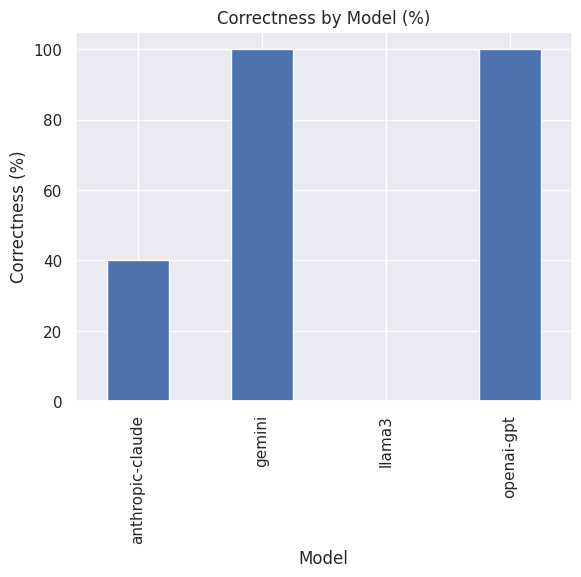

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Overall correctness percentage
overall_correctness = df['correctness'].mean() * 100
print(f"Overall Correctness: {overall_correctness:.2f}%")

# Correctness grouped by model
correctness_by_model = df.groupby('model')['correctness'].mean() * 100
print("\nCorrectness by Model (%):")
print(correctness_by_model)

# Visualize correctness by model
correctness_by_model.plot(kind='bar', title="Correctness by Model (%)", ylabel="Correctness (%)", xlabel="Model");

**JSON Validity**
1. Percentage of valid JSON outputs.
2. Group by model to see which produces valid JSON most consistently.

Overall JSON Validity: 60.00%

JSON Validity by Model (%):
model
anthropic-claude     40.0
gemini              100.0
llama3                0.0
openai-gpt          100.0
Name: IsValidJSON, dtype: float64


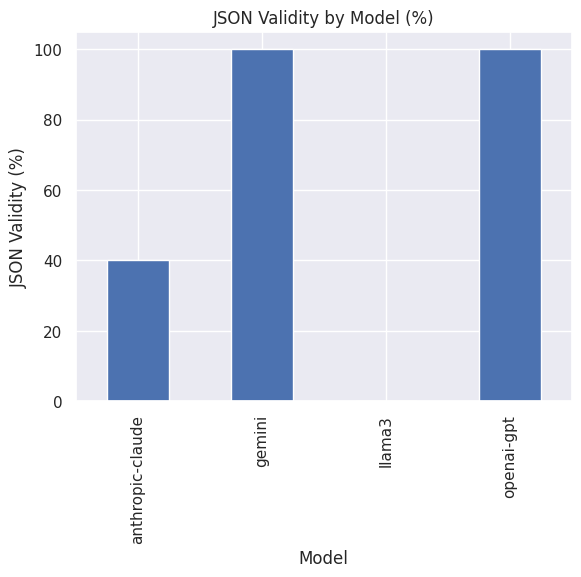

In [16]:
# Overall JSON validity percentage
json_validity = df['IsValidJSON'].mean() * 100
print(f"Overall JSON Validity: {json_validity:.2f}%")

# JSON validity grouped by model
json_validity_by_model = df.groupby('model')['IsValidJSON'].mean() * 100
print("\nJSON Validity by Model (%):")
print(json_validity_by_model)

# Visualize JSON validity
json_validity_by_model.plot(kind='bar', title="JSON Validity by Model (%)", ylabel="JSON Validity (%)", xlabel="Model");

**Latency Analysis**
1. Average latency across models.
2. Compare correctness vs. latency (e.g., scatter plot or grouped analysis).


Average Latency by Model (seconds):
model
anthropic-claude    17.731596
gemini               3.675319
llama3               1.519041
openai-gpt           3.688607
Name: latency, dtype: float64


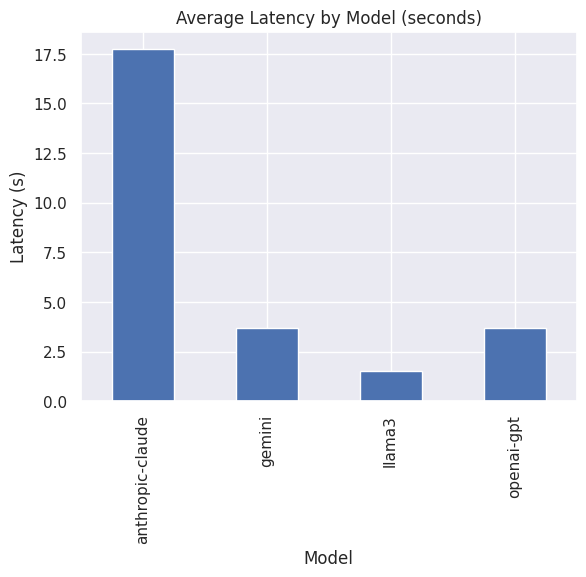

In [17]:
# Average latency by model
average_latency = df.groupby('model')['latency'].mean()
print("\nAverage Latency by Model (seconds):")
print(average_latency)

# Visualize latency
average_latency.plot(kind='bar', title="Average Latency by Model (seconds)", ylabel="Latency (s)", xlabel="Model");

**Combine Metrics**

Analyze trade-offs between correctness, latency, and JSON validity.


Model Performance Summary:
                  Correctness  JSON_Validity  Average_Latency
model                                                        
anthropic-claude         40.0           40.0        17.731596
gemini                  100.0          100.0         3.675319
llama3                    0.0            0.0         1.519041
openai-gpt              100.0          100.0         3.688607


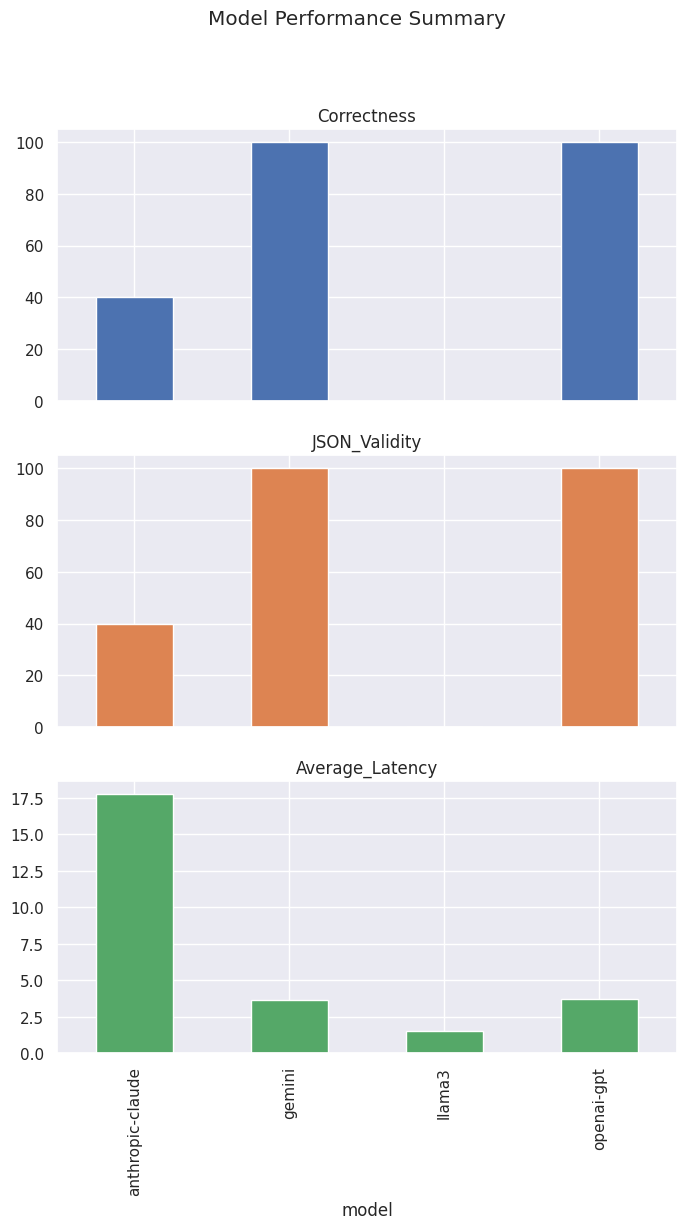

In [18]:
# Combine metrics into a single summary
summary = df.groupby('model').agg(
    Correctness=('correctness', 'mean'),
    JSON_Validity=('IsValidJSON', 'mean'),
    Average_Latency=('latency', 'mean')
)

# Convert percentages for readability
summary['Correctness'] *= 100
summary['JSON_Validity'] *= 100

# Display summary
print("\nModel Performance Summary:")
print(summary)

# Plot summary metrics
summary.plot(kind='bar', title="Model Performance Summary", subplots=True, layout=(3, 1), figsize=(8, 12), legend=False);

## Choosing a Model: Rationale and Next Steps

### Overview
Based on the results of our first experiment, we evaluated the models on key metrics such as **correctness**, **JSON validity**, **latency**, and **cost**. After analyzing the data, we’ve made a decision about which model to proceed with.

---

### Model Evaluation

1. **Valid JSON Out-of-the-Box**:
   - Both **Gemini** and **OpenAI** consistently return valid JSON without requiring adjustments.
   - JSON validity directly correlates with correctness: invalid JSON often indicates errors in the model’s response.

2. **High Correctness**:
   - Gemini and OpenAI are the only models to achieve high correctness scores.

3. **Latency**:
   - Both Gemini and OpenAI have similar average latency, providing fast responses.

4. **Cost**:
   - **Gemini** offers a free tier with 15 requests per minute, making it the more cost-effective option for experimentation.
   - **OpenAI** requires payment, making it less accessible for our current use case.

---

### Decision
We have chosen **Gemini** as the model to use moving forward. It provides:
- High correctness.
- Consistent JSON validity.
- Low latency.
- Cost-effective access via its free tier.

---

### Next Steps

1. **Prompt Refinement**:
   - Address the recurring issue where some "current roles" are misclassified under "previous roles."
   - Update the prompt to:
     - Explicitly state how multiple current roles should be handled.
     - Test the updated prompt for correctness and consistency.

2. **Test at Scale**:
   - Use Gemini to process multiple profiles from the dataset to evaluate the refined prompt.
   - Ensure that results remain correct and consistent across a larger sample.

3. **Document Results**:
   - Capture the impact of prompt adjustments with examples before and after the changes.

---

### Summary
This process highlights how to evaluate models based on metrics like correctness, latency, and cost. It also emphasizes the importance of iterative prompt refinement to address observed issues and improve results. 

With Gemini selected, the next step is to refine the prompt and test it at scale.

## The New Prompt(s)

### Refining the Prompt for Improved Accuracy

In this section, we address a consistent issue where the initial prompt often misclassified some **current roles** as **previous roles** in the extracted data. To improve accuracy, we have applied prompt engineering techniques to ensure the model correctly identifies and categorizes all active roles under **Current Role**.

The updated prompt explicitly emphasizes:
- **Including all ongoing roles** under **Current Role**, even if the candidate has multiple simultaneous roles.
- **Excluding ongoing roles** from the **Previous Roles** section, which should only contain completed positions.
- Adding clear formatting and detailed instructions to reduce ambiguity in the model's interpretation.

By iterating on the prompt, we aim to align the model's output more closely with our expectations, minimizing classification errors and improving the overall quality of the structured data extracted from LinkedIn profiles.

In [19]:
with open("data/anLI.txt", "r") as file:
    profile_content = file.read()

# Updated Prompt for Gemini
prompt = """
Extract the following structured information from the candidate's LinkedIn profile in JSON format:

- "Name": Full name of the candidate.
- "Current Role": The candidate's current title(s) and company(ies) (format: "Title @ Company").
  - Ensure all current roles are included in this section, even if the candidate has multiple simultaneous roles.
  - Do not move any active roles to the "Previous Roles" section.
- "Location": The candidate's location, including city, state, and country.
- "Previous Roles": A list of previous roles with the following details for each:
    - "Title": The role's title.
    - "Company": The company name.
    - "Duration": The dates or duration of the role (e.g., "Feb 2022 - Aug 2024").
    - Exclude any roles that are still ongoing; these belong in "Current Role."
- "Education": A list of education records with the following details for each:
    - "Degree": The degree obtained (e.g., "Bachelor of Science").
    - "Field": The field of study (e.g., "Mathematics").
    - "Institution": The institution's name.
    - "Years": The years of attendance (e.g., "2006 - 2011").
- "Top Skills": A list of the candidate's top 3-5 skills as listed on their LinkedIn profile.

Important:
- Do NOT include any backticks (```) in the response. You may think you're not including them, but you often do. Treat the output as raw JSON text and ensure it is valid.
- Be concise but complete. If any field is missing from the LinkedIn profile, return an empty array or field as appropriate.
"""

# Example of how to combine this with a profile's content
full_prompt = f"{prompt}\n\nLinkedIn Profile:\n{profile_content}"

In [20]:
import time

# Function to run Gemini and validate the output
def test_gemini_single_profile(prompt):
    print("\n[TESTING] Running Gemini on a single profile...")

    start_time = time.time()
    response = generate_output(prompt, "gemini")  # Use your existing function
    latency = time.time() - start_time

    # Print the raw output directly
    print(f"[RAW OUTPUT]: {response}")

    validated_response = validate_json(response)

    # Print validation results
    if validated_response:
        print("[SUCCESS] Valid JSON output:")
        print(validated_response)
    else:
        print("[ERROR] Invalid JSON output:")
        print(response)  # This will reprint the raw response if invalid

    print(f"Latency: {latency:.2f} seconds\n")
    return {
        "Raw Response": response,
        "Validated JSON": validated_response,
        "Latency": latency,
    }

# Run the test
result = test_gemini_single_profile(full_prompt)


[TESTING] Running Gemini on a single profile...
[RAW OUTPUT]: {
  "Name": "Andrew Ng",
  "Current Role": [
    "Founder @ DeepLearning.AI",
    "Managing General Partner @ AI Fund",
    "Executive Chairman (previously CEO) @ LandingAI",
    "Co-Founder and Chairman @ Coursera",
    "Adjunct Professor of Computer Science @ Stanford University"
  ],
  "Location": "Palo Alto, California, United States",
  "Previous Roles": [],
  "Education": [
    {
      "Degree": "Doctor of Philosophy - PhD",
      "Field": "Computer Science",
      "Institution": "University of California, Berkeley",
      "Years": "2003"
    },
    {
      "Degree": "Master of Science - MS",
      "Field": "Electrical Engineering and Computer Science",
      "Institution": "Massachusetts Institute of Technology",
      "Years": "1998"
    }
  ],
  "Top Skills": [
    "Education",
    "Educational Technology"
  ]
}

[SUCCESS] Valid JSON output:
True
Latency: 2.05 seconds



### Iterating on the Prompt to Capture Detailed Dates

While the initial prompt adjustments improved the categorization of **current roles**, it became evident that the model occasionally omitted key details like **start and end dates** for roles. To address this, we further refined the prompt to explicitly request:

- **Start Date**: The beginning of the role, formatted clearly.
- **End Date**: The conclusion of the role, using "Present" for ongoing roles.

This enhancement ensures that both **Current Role** and **Previous Roles** now include detailed timeframes, providing a more complete and structured output. By explicitly emphasizing dates in the schema and adding clear examples, we aim to reduce ambiguity and improve the consistency of the model's responses. This adjustment is critical for applications requiring chronological context, such as candidate evaluation or timeline analysis.

In [21]:
with open("data/anLI.txt", "r") as file:
    profile_content = file.read()

# Updated Prompt for Gemini
prompt = """
Extract the following structured information from the candidate's LinkedIn profile in JSON format:

- "Name": Full name of the candidate.
- "Current Role": A list of the candidate's current role(s) with the following details for each:
    - "Title": The title of the role.
    - "Company": The company name.
    - "Start Date": The start date of the role.
    - "End Date": The end date of the role. Use "Present" if the role is ongoing.
  - Ensure all current roles are included in this section, even if the candidate has multiple simultaneous roles.
  - Do not move any active roles to the "Previous Roles" section.
  - For example:
    "Current Role": [
        {
            "Title": "Founder",
            "Company": "DeepLearning.AI",
            "Start Date": "2017",
            "End Date": "Present"
        },
        {
            "Title": "Managing General Partner",
            "Company": "AI Fund",
            "Start Date": "2018",
            "End Date": "Present"
        }
    ]
- "Location": The candidate's location, including city, state, and country.
- "Previous Roles": A list of previous roles with the following details for each:
    - "Title": The role's title.
    - "Company": The company name.
    - "Start Date": The start date of the role.
    - "End Date": The end date of the role.
    - Exclude any roles that are still ongoing; these belong in "Current Role."
- "Education": A list of education records with the following details for each:
    - "Degree": The degree obtained (e.g., "Bachelor of Science").
    - "Field": The field of study (e.g., "Mathematics").
    - "Institution": The institution's name.
    - "Years": The years of attendance (e.g., "2006 - 2011").
- "Top Skills": A list of the candidate's top 3-5 skills as listed on their LinkedIn profile.

Important:
- Do NOT include any backticks (```) in the response. You may think you're not including them, but you often do. Treat the output as raw JSON text and ensure it is valid.
- Be concise but complete. If any field is missing from the LinkedIn profile, return an empty array or field as appropriate.
"""

# Example of how to combine this with a profile's content
full_prompt = f"{prompt}\n\nLinkedIn Profile:\n{profile_content}"



In [22]:
# Run the test
result = test_gemini_single_profile(full_prompt)


[TESTING] Running Gemini on a single profile...
[RAW OUTPUT]: {
  "Name": "Andrew Ng",
  "Current Role": [
    {
      "Title": "Founder",
      "Company": "DeepLearning.AI",
      "Start Date": "Jun 2017",
      "End Date": "Present"
    },
    {
      "Title": "Managing General Partner",
      "Company": "AI Fund",
      "Start Date": "Jan 2018",
      "End Date": "Present"
    },
    {
      "Title": "Executive Chairman (previously CEO)",
      "Company": "LandingAI",
      "Start Date": "Oct 2017",
      "End Date": "Present"
    },
    {
      "Title": "Co-Founder and Chairman",
      "Company": "Coursera",
      "Start Date": "Jan 2012",
      "End Date": "Present"
    },
    {
      "Title": "Adjunct Professor of Computer Science",
      "Company": "Stanford University",
      "Start Date": "Sep 2002",
      "End Date": "Present"
    }
  ],
  "Location": "Palo Alto, California, United States",
  "Previous Roles": [],
  "Education": [
    {
      "Degree": "Doctor of Philosophy 

### Results After Refining the Prompt

After incorporating explicit instructions in the prompt to include **start and end dates** for each role, the model successfully returned outputs with detailed temporal information. For example, the updated output for Andrew Ng included:

- **Current Role**:
  - `"Founder @ DeepLearning.AI"` with a **Start Date** of "Jun 2017" and an **End Date** of "Present".
  - `"Managing General Partner @ AI Fund"` with a **Start Date** of "Jan 2018" and an **End Date** of "Present".

These improvements highlight how careful prompt engineering can yield more structured and comprehensive results. The inclusion of **date fields** enhances the usability of the data for applications requiring time-sensitive context, such as employment history analysis or project timelines. This demonstrates that iterative refinement of prompts based on output evaluation is critical to achieving high-quality responses.

### Running the Updated Prompt on the Full Dataset

With the refined prompt designed to capture detailed and structured information, this section processes the entire dataset of LinkedIn profiles using the Gemini model. Each profile is fed through the updated prompt to generate structured JSON outputs, which include fields such as **Current Roles** (with start and end dates), **Previous Roles**, and **Education**.

Key highlights:
- Results are validated for JSON structure.
- Latency for each profile is measured.
- Outputs are saved to a CSV file for further analysis.

This step ensures that the refined prompt is applied consistently across the dataset, enabling evaluation of model performance on a larger scale.

In [23]:
import os
import time
import json
import pandas as pd

# Function to process a single LinkedIn profile with the updated prompt
def process_profile(file_path, prompt_template):
    with open(file_path, "r") as file:
        profile_content = file.read()

    # Combine the prompt with the profile content
    full_prompt = f"{prompt_template}\n\nLinkedIn Profile:\n{profile_content}"

    print(f"\n[PROCESSING] File: {os.path.basename(file_path)}")

    start_time = time.time()
    response = generate_output(full_prompt, "gemini")  # Use Gemini model
    latency = time.time() - start_time

    validated_json = validate_json(response)

    # Print the results for transparency
    if validated_json:
        print(f"[SUCCESS] Valid JSON output for {os.path.basename(file_path)}")
    else:
        print(f"[ERROR] Invalid JSON for {os.path.basename(file_path)}")
        print(response)  # Show raw output for debugging

    return {
        "File": os.path.basename(file_path),
        "Raw Response": response,
        "Validated JSON": validated_json,
        "Latency": latency
    }

# Directory containing LinkedIn profile text files
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Updated prompt template
prompt_template = """
Extract the following structured information from the candidate's LinkedIn profile in JSON format:

- "Name": Full name of the candidate.
- "Current Role": The candidate's current title(s) and company(ies) (format: "Title @ Company").
  - Ensure all current roles are included in this section, even if the candidate has multiple simultaneous roles.
  - Do not move any active roles to the "Previous Roles" section.
- "Location": The candidate's location, including city, state, and country.
- "Previous Roles": A list of previous roles with the following details for each:
    - "Title": The role's title.
    - "Company": The company name.
    - "Start Date": The start date of the role.
    - "End Date": The end date of the role (use "Present" for ongoing roles).
  - Exclude any roles that are still ongoing; these belong in "Current Role."
- "Education": A list of education records with the following details for each:
    - "Degree": The degree obtained (e.g., "Bachelor of Science").
    - "Field": The field of study (e.g., "Mathematics").
    - "Institution": The institution's name.
    - "Years": The years of attendance (e.g., "2006 - 2011").
- "Top Skills": A list of the candidate's top 3-5 skills as listed on their LinkedIn profile.

Important:
- Do NOT include any backticks (```) in the response. You may think you're not including them, but you often do. Treat the output as raw JSON text and ensure it is valid.
- Be concise but complete. If any field is missing from the LinkedIn profile, return an empty array or field as appropriate.
"""

# Process each file in the dataset
results = []
for file_path in files:
    result = process_profile(file_path, prompt_template)
    results.append(result)

# Save results to a DataFrame
df = pd.DataFrame(results)

# Save results to a CSV for further analysis
df.to_csv("data/gemini_full_dataset_results.csv", index=False)
print("\n[COMPLETE] Results saved to 'gemini_full_dataset_results.csv'")

# Summarize results
valid_count = df["Validated JSON"].notnull().sum()
invalid_count = len(df) - valid_count
average_latency = df["Latency"].mean()

print(f"\n[SUMMARY]")
print(f"Total Profiles Processed: {len(df)}")
print(f"Valid JSON Outputs: {valid_count}")
print(f"Invalid JSON Outputs: {invalid_count}")
print(f"Average Latency: {average_latency:.2f} seconds")


[PROCESSING] File: hhLI.txt
[SUCCESS] Valid JSON output for hhLI.txt

[PROCESSING] File: cwLI.txt
[SUCCESS] Valid JSON output for cwLI.txt

[PROCESSING] File: skLI.txt
[SUCCESS] Valid JSON output for skLI.txt

[PROCESSING] File: anLI.txt
[SUCCESS] Valid JSON output for anLI.txt

[PROCESSING] File: hbaLI.txt
[SUCCESS] Valid JSON output for hbaLI.txt

[COMPLETE] Results saved to 'gemini_full_dataset_results.csv'

[SUMMARY]
Total Profiles Processed: 5
Valid JSON Outputs: 5
Invalid JSON Outputs: 0
Average Latency: 2.90 seconds


### Reviewing the Results

After generating and saving the outputs to a CSV file, the next step is to review the results manually. Open the CSV file in a spreadsheet tool and perform the following actions:

1. **Correctness Column**: Add a column titled "Correctness" where you can mark each row as `1` (correct) or `0` (incorrect) based on whether the output matches expectations.
2. **Notes Column**: Add a column titled "Notes" to record any observations, such as anomalies, missing fields, or interesting patterns in the data. This column can also capture examples of recurring issues, if any.
3. Review the data thoroughly to assess how well the updated prompt and model performed across different profiles.

This manual review will help identify areas where the prompt or the model might need further adjustments for improved consistency and accuracy.

# Eyeballing Results from Gemini Full Dataset Validation

## Key Observations
1. **Validation of JSON**:
   - All responses are valid JSON. This consistency is a positive indicator that Gemini reliably adheres to the structured output format.

2. **Current Roles**:
   - Ongoing roles are correctly listed under the "Current Role" section and not misplaced in "Previous Roles." This aligns well with our updated prompt.

3. **Previous Roles**:
   - The "Previous Roles" field seems sparse, raising concerns about whether some roles may have been missed. For example, there appears to be one role missing for Hamel. This could indicate potential gaps in the extraction process, which might become clearer when we run additional iterations.

4. **Dates**:
   - Dates are included in the "Current Role" section, with "Start Date" and "End Date" accurately extracted, and "End Date" is marked as "Present" for ongoing roles. This is a significant improvement over earlier outputs.

5. **Education**:
   - The "Education" field is structured and includes details like "Degree," "Field," "Institution," and "Years." However, as with previous roles, some profiles may be missing education records, either due to gaps in the LinkedIn data or limitations in extraction.

6. **Top Skills**:
   - The "Top Skills" field is populated in most cases, but it would be helpful to review whether it consistently captures the most relevant skills.

## Additional Observations
- **Potential Flip-Floppy Behavior**:
   - To assess stability, we need to run multiple iterations for each profile. If Gemini alternates between extracting and omitting details (e.g., roles or skills), it would highlight potential consistency issues.
   - For instance, Hamel’s output may serve as a good case to evaluate whether missing roles are a one-off error or part of a broader inconsistency.

## Strengths
- Gemini handles structured output effectively.
- JSON validity and adherence to the prompt have been excellent.
- Dates and the separation of current/previous roles are significantly improved.

## Weaknesses
- Potential gaps in "Previous Roles" and "Top Skills" for certain profiles.
- Limited information on whether omissions are due to profile content or model behavior.



## Iterative Evaluation for Consistency

To ensure the stability and reliability of the Gemini model's outputs, this section introduces a process to run multiple iterations of the same profile. By executing the model 10 times per LinkedIn profile, we can investigate potential inconsistencies, such as "flip-floppy" behavior, where details may change across iterations. 

The code collects outputs, validates their JSON format, and logs the latency for each run. Results are saved to a CSV file for further analysis, where consistency across iterations can be evaluated systematically. This approach provides deeper insights into the model's performance, allowing us to identify patterns, potential gaps, and areas for improvement.

In [24]:
import os
import time
import json
import pandas as pd

# Function to process a LinkedIn profile with multiple iterations
def process_profile_multiple_runs(file_path, prompt_template, num_runs=10):
    with open(file_path, "r") as file:
        profile_content = file.read()

    # Combine the prompt with the profile content
    full_prompt = f"{prompt_template}\n\nLinkedIn Profile:\n{profile_content}"

    print(f"\n[PROCESSING] File: {os.path.basename(file_path)}")

    results = []  # Store results for this file
    for run_num in range(1, num_runs + 1):
        print(f"\n[RUN {run_num}]")

        start_time = time.time()
        response = generate_output(full_prompt, "gemini")  # Use Gemini model
        latency = time.time() - start_time

        validated_json = validate_json(response)

        # Print the results for transparency
        if validated_json:
            print(f"[SUCCESS] Valid JSON output for {os.path.basename(file_path)}")
        else:
            print(f"[ERROR] Invalid JSON for {os.path.basename(file_path)}")
            print(response)  # Show raw output for debugging

        results.append({
            "Run": run_num,
            "Raw Response": response,
            "Validated JSON": validated_json,
            "Latency": latency
        })

    return results

# Directory containing LinkedIn profile text files
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Process each file in the dataset
all_results = []
for file_path in files:
    result = process_profile_multiple_runs(file_path, prompt_template, num_runs=10)
    all_results.extend(result)

# Save results to a DataFrame
df = pd.DataFrame(all_results)

# Save results to a CSV for further analysis
df.to_csv("gemini_full_dataset_10_iterations_results.csv", index=False)
print("\n[COMPLETE] Results saved to 'gemini_full_dataset_10_iterations_results.csv'")

# Summarize results
valid_count = df["Validated JSON"].notnull().sum()
invalid_count = len(df) - valid_count
average_latency = df["Latency"].mean()

print(f"\n[SUMMARY]")
print(f"Total Profiles Processed: {len(df)}")
print(f"Valid JSON Outputs: {valid_count}")
print(f"Invalid JSON Outputs: {invalid_count}")
print(f"Average Latency: {average_latency:.2f} seconds")


[PROCESSING] File: hhLI.txt

[RUN 1]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 2]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 3]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 4]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 5]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 6]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 7]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 8]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 9]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 10]
[SUCCESS] Valid JSON output for hhLI.txt

[PROCESSING] File: cwLI.txt

[RUN 1]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 2]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 3]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 4]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 5]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 6]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 7]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 8]
[SUCCESS] Valid JSON output for cwLI.txt

[RUN 9]
[SUCCESS] Valid JSON output for 

## Rate-Limited Iterative Evaluation

Gemini has a rate limit of 15 requests per minute, which can lead to timeouts when processing multiple iterations of profiles in quick succession. To address this, we implement rate-limiting logic to ensure compliance with Gemini's constraints while maintaining efficiency.

The updated code enforces a rate limit of 10 requests per minute, introducing a short delay between consecutive requests to avoid exceeding the limit. This ensures uninterrupted processing and reliable output collection. By spacing out requests, we reduce the risk of errors while still achieving consistent iterations for evaluation purposes.

The results are saved to a CSV file, providing a comprehensive dataset for further analysis. This approach balances efficiency and stability while respecting the API's rate limits.

In [25]:
import os
import time
import json
import pandas as pd

# Store the time of the last request
last_request_time = 0
rate_limit_seconds = 60  # 1 minute
requests_per_minute = 10  # 15 requests per minute
time_between_requests = rate_limit_seconds / requests_per_minute  # Time between each request

# Function to check and enforce the rate limit
def enforce_rate_limit():
    global last_request_time
    
    # Get the current time
    current_time = time.time()
    
    # Calculate the elapsed time since the last request
    time_elapsed = current_time - last_request_time
    
    # If the last request was made too recently, we need to wait
    if time_elapsed < time_between_requests:
        wait_time = time_between_requests - time_elapsed
        print(f"[INFO] Waiting for {wait_time:.2f} seconds to comply with rate limit...")
        time.sleep(wait_time)  # Sleep until enough time has passed
    
    # Update the last request time after making a request
    last_request_time = time.time()

# Function to process a LinkedIn profile with multiple iterations
def process_profile_multiple_runs(file_path, prompt_template, num_runs=10):
    with open(file_path, "r") as file:
        profile_content = file.read()

    # Combine the prompt with the profile content
    full_prompt = f"{prompt_template}\n\nLinkedIn Profile:\n{profile_content}"

    print(f"\n[PROCESSING] File: {os.path.basename(file_path)}")

    results = []  # Store results for this file
    for run_num in range(1, num_runs + 1):
        print(f"\n[RUN {run_num}]")

        # Ensure we comply with the rate limit before making the request
        enforce_rate_limit()

        # Start the timer for latency measurement
        start_time = time.time()
        
        # Generate the output using the model (Gemini in this case)
        response = generate_output(full_prompt, "gemini")
        
        # Measure the time taken for the request
        latency = time.time() - start_time

        validated_json = validate_json(response)

        # Print the results for transparency
        if validated_json:
            print(f"[SUCCESS] Valid JSON output for {os.path.basename(file_path)}")
        else:
            print(f"[ERROR] Invalid JSON for {os.path.basename(file_path)}")
            print(response)  # Show raw output for debugging

        # Append the results for this run
        results.append({
            "File": file_path,
            "Run": run_num,
            "Raw Response": response,
            "Validated JSON": validated_json,
            "Latency": latency
        })

    return results

# Directory containing LinkedIn profile text files
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Process each file in the dataset
all_results = []
for file_path in files:
    result = process_profile_multiple_runs(file_path, prompt_template, num_runs=10)
    all_results.extend(result)

# Save results to a DataFrame
df = pd.DataFrame(all_results)

# Save results to a CSV for further analysis
df.to_csv("gemini_full_dataset_10_iterations_results.csv", index=False)
print("\n[COMPLETE] Results saved to 'gemini_full_dataset_10_iterations_results.csv'")

# Summarize results
valid_count = df["Validated JSON"].notnull().sum()
invalid_count = len(df) - valid_count
average_latency = df["Latency"].mean()

print(f"\n[SUMMARY]")
print(f"Total Profiles Processed: {len(df)}")
print(f"Valid JSON Outputs: {valid_count}")
print(f"Invalid JSON Outputs: {invalid_count}")
print(f"Average Latency: {average_latency:.2f} seconds")


[PROCESSING] File: hhLI.txt

[RUN 1]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 2]
[INFO] Waiting for 3.12 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 3]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 4]
[INFO] Waiting for 3.46 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 5]
[INFO] Waiting for 1.84 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 6]
[INFO] Waiting for 3.27 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 7]
[INFO] Waiting for 1.86 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 8]
[INFO] Waiting for 3.26 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 9]
[INFO] Waiting for 2.87 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 10]
[INFO] Waiting for 2.72 seconds to comply with rate limit...
[SUCCESS] Valid JSON ou

## Exploring the Dataset

With the dataset created from the iterative processing of LinkedIn profiles using Gemini, we can begin an exploratory analysis to assess consistency, latency, and overall adherence to the prompt. This exploration provides insight into the stability and reliability of the model's output across multiple runs.

### Key Columns in the Dataset:
- **File**: The file path of the LinkedIn profile being processed.
- **Run**: The iteration number for each profile (e.g., 1 through 10).
- **Raw Response**: The raw JSON response from the model for that iteration.
- **Validated JSON**: Indicates whether the response was successfully validated as JSON (`True` or `False`).
- **Latency**: The time taken (in seconds) to generate the response for that iteration.

### Initial Observations:
The dataset shows:
1. **Consistent JSON Validation**: All rows have `Validated JSON` as `True`, which is promising.
2. **Latency Analysis**: Latency values provide insight into the response times across different iterations and profiles.
3. **Variability in `Raw Response`**: Initial inspection of the raw responses shows potential differences in capitalization, formatting, or content that may warrant further analysis.

Next, we will dive deeper into specific fields (e.g., Name, Current Role, Education) to identify any inconsistencies or patterns across the multiple runs for each profile.

In [44]:
df = pd.read_csv("gemini_full_dataset_10_iterations_results.csv")
df.columns

Index(['File', 'Run', 'Raw Response', 'Validated JSON', 'Latency'], dtype='object')

In [45]:
df.head()

,File,Run,Raw Response,Validated JSON,Latency
0,data/hhLI.txt,1,"{\n ""Name"": ""Hamel Husain"",\n ""Current Role""...",True,2.877580
1,data/hhLI.txt,2,"{\n ""Name"": ""Hamel Husain"",\n ""Current Role""...",True,12.485634
2,data/hhLI.txt,3,"{\n ""Name"": ""Hamel Husain"",\n ""Current Role""...",True,2.536514
3,data/hhLI.txt,4,"{\n ""Name"": ""Hamel Husain"",\n ""Current Role""...",True,4.155146
4,data/hhLI.txt,5,"{\n ""Name"": ""Hamel Husain"",\n ""Current Role""...",True,2.730536


##  Checking for Field-Level Inconsistencies
In this section, we begin by printing field values (starting with names) directly to the terminal to quickly identify inconsistencies across multiple runs of the same profile. By comparing values such as “Name,” “Current Role,” and others field by field, we aim to pinpoint variations or patterns that could indicate model flip-flopping or other issues in the output. This straightforward exploration helps us validate the stability and reliability of the generated outputs before diving deeper into more automated analysis.

In [46]:

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the name from the raw response (assuming it's a valid JSON string)
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Default to 'Name not found' if not present
        print(f"[RUN {index + 1}] - {name}")  # Print the name
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Hamel Husain
[RUN 2] - Hamel Husain
[RUN 3] - Hamel Husain
[RUN 4] - Hamel Husain
[RUN 5] - Hamel Husain
[RUN 6] - Hamel Husain
[RUN 7] - Hamel Husain
[RUN 8] - Hamel Husain
[RUN 9] - Hamel Husain
[RUN 10] - Hamel Husain
[RUN 11] - Chris Wiggins
[RUN 12] - chris wiggins
[RUN 13] - Chris Wiggins
[RUN 14] - chris wiggins
[RUN 15] - chris wiggins
[RUN 16] - Chris Wiggins
[RUN 17] - chris wiggins
[RUN 18] - chris wiggins
[RUN 19] - Chris Wiggins
[RUN 20] - chris wiggins
[RUN 21] - Stefan Krawczyk
[RUN 22] - Stefan Krawczyk
[RUN 23] - Stefan Krawczyk
[RUN 24] - Stefan Krawczyk
[RUN 25] - Stefan Krawczyk
[RUN 26] - Stefan Krawczyk
[RUN 27] - Stefan Krawczyk
[RUN 28] - Stefan Krawczyk
[RUN 29] - Stefan Krawczyk
[RUN 30] - Stefan Krawczyk
[RUN 31] - Andrew Ng
[RUN 32] - Andrew Ng
[RUN 33] - Andrew Ng
[RUN 34] - Andrew Ng
[RUN 35] - Andrew Ng
[RUN 36] - Andrew Ng
[RUN 37] - Andrew Ng
[RUN 38] - Andrew Ng
[RUN 39] - Andrew Ng
[RUN 40] - Andrew Ng
[RUN 41] - Hugo Bowne-Anderson
[RUN 42]

In [47]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the raw response and parse it as JSON
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Extract the Name
        current_roles = raw_response.get('Current Role', 'Current Role not found')  # Extract the Current Role

        print(f"[RUN {index + 1}] - Name: {name}, Current Role: {current_roles}")  # Print Name and Current Role
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Name: Hamel Husain, Current Role: Independent Consultant @ Parlance Labs
[RUN 2] - Name: Hamel Husain, Current Role: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital']
[RUN 3] - Name: Hamel Husain, Current Role: Independent Consultant @ Parlance Labs
[RUN 4] - Name: Hamel Husain, Current Role: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital']
[RUN 5] - Name: Hamel Husain, Current Role: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital']
[RUN 6] - Name: Hamel Husain, Current Role: Independent Consultant @ Parlance Labs, Scout @ Bain Capital, R&D @ AnswerAI
[RUN 7] - Name: Hamel Husain, Current Role: Independent Consultant @ Parlance Labs
[RUN 8] - Name: Hamel Husain, Current Role: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital']
[RUN 9] - Name: Hamel Husain, Current Role: Independent Consultant @ Parlance Labs
[RUN 10] - Name: Hamel Husain, 

In [48]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the raw response and parse it as JSON
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Extract the Name
        education = raw_response.get('Education', 'Education not found')  # Extract Education

        print(f"[RUN {index + 1}] - Name: {name}, Education: {education}")  # Print Name and Education
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Name: Hamel Husain, Education: [{'Degree': 'Master of Science (M.S.), Computer Science, Machine Learning', 'Field': 'Computer Science, Machine Learning', 'Institution': 'Georgia Institute of Technology', 'Years': None}, {'Degree': 'Doctor of Law (J.D.), Cum Laude', 'Field': None, 'Institution': 'University of Michigan', 'Years': None}]
[RUN 2] - Name: Hamel Husain, Education: [{'Degree': 'Master of Science (M.S.), Computer Science, Machine Learning', 'Field': 'Computer Science, Machine Learning', 'Institution': 'Georgia Institute of Technology', 'Years': None}, {'Degree': 'Doctor of Law (J.D.), Cum Laude', 'Field': None, 'Institution': 'University of Michigan', 'Years': None}]
[RUN 3] - Name: Hamel Husain, Education: [{'Degree': 'Master of Science (M.S.), Computer Science, Machine Learning', 'Field': 'Computer Science, Machine Learning', 'Institution': 'Georgia Institute of Technology', 'Years': None}, {'Degree': 'Doctor of Law (J.D.), Cum Laude', 'Field': None, 'Institution'

In [49]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the raw response and parse it as JSON
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Extract the Name
        previous_roles = raw_response.get('Previous Roles', 'Previous Roles not found')  # Extract Previous Roles

        print(f"[RUN {index + 1}] - Name: {name}, Previous Roles: {previous_roles}")  # Print Name and Previous Roles
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Name: Hamel Husain, Previous Roles: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Duration': 'Aug 2022 - May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Duration': 'Sep 2019 - Aug 2022'}, {'Title': 'Head of ML & Data Science', 'Company': 'Outerbounds', 'Duration': 'Jan 2022 - Aug 2022'}]
[RUN 2] - Name: Hamel Husain, Previous Roles: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Start Date': 'Aug 2022', 'End Date': 'May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Start Date': 'Sep 2019', 'End Date': 'Aug 2022'}, {'Title': 'Head of ML & Data Science', 'Company': 'Outerbounds', 'Start Date': 'Jan 2022', 'End Date': 'Aug 2022'}]
[RUN 3] - Name: Hamel Husain, Previous Roles: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Duration': 'Aug 2022 - May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Duration': 'Sep 2019 - Aug 2022'}, {'Title': 'Head of

In [50]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the raw response and parse it as JSON
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Extract the Name
        location = raw_response.get('Location', 'Location not found')  # Extract Location

        print(f"[RUN {index + 1}] - Name: {name}, Location: {location}")  # Print Name and Location
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Name: Hamel Husain, Location: United States
[RUN 2] - Name: Hamel Husain, Location: United States
[RUN 3] - Name: Hamel Husain, Location: United States
[RUN 4] - Name: Hamel Husain, Location: United States
[RUN 5] - Name: Hamel Husain, Location: United States
[RUN 6] - Name: Hamel Husain, Location: United States
[RUN 7] - Name: Hamel Husain, Location: United States
[RUN 8] - Name: Hamel Husain, Location: United States
[RUN 9] - Name: Hamel Husain, Location: United States
[RUN 10] - Name: Hamel Husain, Location: United States
[RUN 11] - Name: Chris Wiggins, Location: New York, New York, United States
[RUN 12] - Name: chris wiggins, Location: New York, New York, United States
[RUN 13] - Name: Chris Wiggins, Location: New York, New York, United States
[RUN 14] - Name: chris wiggins, Location: New York, New York, United States
[RUN 15] - Name: chris wiggins, Location: New York, New York, United States
[RUN 16] - Name: Chris Wiggins, Location: New York, New York, United States
[RU

In [51]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Extract the raw response and parse it as JSON
    try:
        raw_response = json.loads(row['Raw Response'])
        name = raw_response.get('Name', 'Name not found')  # Extract the Name
        top_skills = raw_response.get('Top Skills', 'Top Skills not found')  # Extract Top Skills

        print(f"[RUN {index + 1}] - Name: {name}, Top Skills: {top_skills}")  # Print Name and Top Skills
    except Exception as e:
        print(f"[ERROR] Unable to parse JSON for row {index + 1}: {e}")

[RUN 1] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 2] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 3] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 4] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 5] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 6] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 7] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 8] - Name: Hamel Husain, Top Skills: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science']
[RUN 9] - Name: Hamel Husain, To

## Summarizing Field-Level Consistencies

In this section, we expand on our earlier exploration by systematically analyzing the frequency of field values across multiple runs for each profile. Using a combination of JSON parsing and frequency counting, we compare values for fields like “Name,” “Current Role,” “Previous Roles,” “Top Skills,” and “Education.”

This process helps us summarize inconsistencies in a structured format, providing a clearer view of how often values vary or remain consistent. The results are saved to a CSV file (consistency_summary.csv) for further analysis, allowing us to identify patterns or issues at a glance.

In [52]:
df.columns

Index(['File', 'Run', 'Raw Response', 'Validated JSON', 'Latency'], dtype='object')

In [53]:
import json
import pandas as pd

# Define the fields in the JSON you want to compare
fields_to_compare = ["Name", "Current Role", "Previous Roles", "Top Skills", "Education"]

# List to store the results
results = []

# Iterate over each file (or profile) in the dataset
profiles = df['File'].unique()  # Replace 'File' with your actual column name if different

for profile in profiles:
    print(f"\n[ANALYZING FILE]: {profile}")
    profile_data = df[df['File'] == profile]  # Filter rows for the current file/profile
    
    # Loop through fields and count occurrences
    for field in fields_to_compare:
        print(f"\nField: {field}")
        field_values = []

        # Extract the values for the current field across runs
        for _, row in profile_data.iterrows():
            try:
                raw_json = json.loads(row['Raw Response'])  # Parse the JSON
                field_value = raw_json.get(field, "Field not found")  # Extract the field
                field_values.append(str(field_value))  # Convert to string for comparison
            except json.JSONDecodeError:
                field_values.append("Invalid JSON")
        
        # Calculate frequencies of the values
        value_counts = {value: field_values.count(value) for value in set(field_values)}

        # Print the frequencies for the current field
        for value, count in value_counts.items():
            print(f"Value: {value} | Frequency: {count}")
            
            # Append to results
            results.append({
                "File": profile,
                "Field": field,
                "Value": value,
                "Frequency": count
            })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
output_csv = "field_value_frequencies.csv"
df_results.to_csv(output_csv, index=False)
print(f"\n[COMPLETE] Results saved to '{output_csv}'")


[ANALYZING FILE]: data/hhLI.txt

Field: Name
Value: Hamel Husain | Frequency: 10

Field: Current Role
Value: Independent Consultant @ Parlance Labs | Frequency: 5
Value: Independent Consultant @ Parlance Labs, Scout @ Bain Capital, R&D @ AnswerAI | Frequency: 1
Value: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital'] | Frequency: 4

Field: Previous Roles
Value: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Start Date': 'Aug 2022', 'End Date': 'May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Start Date': 'Sep 2019', 'End Date': 'Aug 2022'}, {'Title': 'Head of ML & Data Science', 'Company': 'Outerbounds', 'Start Date': 'Jan 2022', 'End Date': 'Aug 2022'}] | Frequency: 1
Value: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Duration': 'Aug 2022 - May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Duration': 'Sep 2019 - Aug 2022'}, {'Title': 'Head of ML & Data Scien

## Results: Field-Level Consistency Analysis

Here are the summarized results from analyzing the consistency of field values across multiple runs for each profile. This detailed breakdown highlights patterns and potential inconsistencies in the data extracted by the model for each field:

### Key Findings

1. **Name**:  
   For most profiles, the name remains consistent across runs, but minor variations in capitalization (e.g., "chris wiggins" vs. "Chris Wiggins") suggest some inconsistency in output formatting.

2. **Current Role**:  
   This field displays significant variability, particularly in cases where multiple roles are listed. Some outputs use concatenated strings, while others use structured lists. Additionally, role details like separators (`;` vs. `,`) and extra role information (e.g., action editors or additional affiliations) vary across runs.

3. **Previous Roles**:  
   For several profiles, inconsistencies arise in the formatting of roles, especially in the inclusion or omission of durations (`Start Date`, `End Date`, or `Duration`). For example:
   - Some outputs contain structured details with precise dates.
   - Others group roles with generic `Duration` fields, leading to variation.

4. **Top Skills**:  
   Skill lists vary significantly across runs, both in content and order. While the overall content remains largely relevant, discrepancies in the number of skills included (e.g., top 3 vs. 5 skills) and their order suggest instability.

5. **Education**:  
   Education details are largely consistent, but minor variations occur in fields such as `Degree`, `Field`, or `Institution`. For example:
   - "Master of Science" sometimes appears fully spelled out, while other times it is abbreviated as "M.S."
   - Some runs omit specific distinctions like "with Distinction in Research."

### Key Observations

- Profiles like **Hugo Bowne-Anderson** and **Stefan Krawczyk** exhibit notable consistency across most fields.
- Profiles like **Chris Wiggins** and **Andrew Ng** show more frequent inconsistencies, particularly in fields like "Current Role" and "Previous Roles."
- The output format for structured fields, such as "Current Role" and "Previous Roles," demonstrates variability between runs, impacting reliability.

### Next Steps

- Testing!

In [36]:
full_prompt

'\nExtract the following structured information from the candidate\'s LinkedIn profile in JSON format:\n\n- "Name": Full name of the candidate.\n- "Current Role": A list of the candidate\'s current role(s) with the following details for each:\n    - "Title": The title of the role.\n    - "Company": The company name.\n    - "Start Date": The start date of the role.\n    - "End Date": The end date of the role. Use "Present" if the role is ongoing.\n  - Ensure all current roles are included in this section, even if the candidate has multiple simultaneous roles.\n  - Do not move any active roles to the "Previous Roles" section.\n  - For example:\n    "Current Role": [\n        {\n            "Title": "Founder",\n            "Company": "DeepLearning.AI",\n            "Start Date": "2017",\n            "End Date": "Present"\n        },\n        {\n            "Title": "Managing General Partner",\n            "Company": "AI Fund",\n            "Start Date": "2018",\n            "End Date": "P

## Experimenting with Temperature 

In am attempt to increase the consistency here, let's decrease temperature:

In [37]:
gemini_model = genai.GenerativeModel("gemini-1.5-flash")
response = gemini_model.generate_content(full_prompt, generation_config = genai.GenerationConfig(
        temperature=0.1
    ))
response.text

'{\n  "Name": "Andrew Ng",\n  "Current Role": [\n    {\n      "Title": "Founder",\n      "Company": "DeepLearning.AI",\n      "Start Date": "Jun 2017",\n      "End Date": "Present"\n    },\n    {\n      "Title": "Managing General Partner",\n      "Company": "AI Fund",\n      "Start Date": "Jan 2018",\n      "End Date": "Present"\n    },\n    {\n      "Title": "Executive Chairman (previously CEO)",\n      "Company": "LandingAI",\n      "Start Date": "Oct 2017",\n      "End Date": "Present"\n    },\n    {\n      "Title": "Co-Founder and Chairman",\n      "Company": "Coursera",\n      "Start Date": "Jan 2012",\n      "End Date": "Present"\n    },\n    {\n      "Title": "Adjunct Professor of Computer Science",\n      "Company": "Stanford University",\n      "Start Date": "Sep 2002",\n      "End Date": "Present"\n    }\n  ],\n  "Location": "Palo Alto, California, United States",\n  "Previous Roles": [],\n  "Education": [\n    {\n      "Degree": "Doctor of Philosophy - PhD",\n      "Field": 

In [38]:
import os
import time
import json
import pandas as pd

# Initialize the Gemini model
gemini_model = genai.GenerativeModel("gemini-1.5-flash")

# Store the time of the last request
last_request_time = 0
rate_limit_seconds = 60  # 1 minute
requests_per_minute = 10  # 15 requests per minute
time_between_requests = rate_limit_seconds / requests_per_minute  # Time between each request

# Function to check and enforce the rate limit
def enforce_rate_limit():
    global last_request_time
    
    # Get the current time
    current_time = time.time()
    
    # Calculate the elapsed time since the last request
    time_elapsed = current_time - last_request_time
    
    # If the last request was made too recently, we need to wait
    if time_elapsed < time_between_requests:
        wait_time = time_between_requests - time_elapsed
        print(f"[INFO] Waiting for {wait_time:.2f} seconds to comply with rate limit...")
        time.sleep(wait_time)  # Sleep until enough time has passed
    
    # Update the last request time after making a request
    last_request_time = time.time()

# Function to process a LinkedIn profile with multiple iterations
def process_profile_multiple_runs(file_path, prompt_template, num_runs=10, temperature=0.0):
    with open(file_path, "r") as file:
        profile_content = file.read()

    # Combine the prompt with the profile content
    full_prompt = f"{prompt_template}\n\nLinkedIn Profile:\n{profile_content}"

    print(f"\n[PROCESSING] File: {os.path.basename(file_path)}")

    results = []  # Store results for this file
    for run_num in range(1, num_runs + 1):
        print(f"\n[RUN {run_num}]")

        # Ensure we comply with the rate limit before making the request
        enforce_rate_limit()

        # Start the timer for latency measurement
        start_time = time.time()
        
        # Generate the output using the Gemini model with the specified temperature
        try:
            response = gemini_model.generate_content(
                full_prompt, 
                generation_config=genai.GenerationConfig(temperature=temperature)
            )
            response_text = response.text
        except Exception as e:
            print(f"[ERROR] Failed to generate content: {e}")
            response_text = None

        # Measure the time taken for the request
        latency = time.time() - start_time

        # Validate the JSON response
        validated_json = validate_json(response_text)

        # Print the results for transparency
        if validated_json:
            print(f"[SUCCESS] Valid JSON output for {os.path.basename(file_path)}")
        else:
            print(f"[ERROR] Invalid JSON for {os.path.basename(file_path)}")
            print(response_text)  # Show raw output for debugging

        # Append the results for this run
        results.append({
            "File": file_path,
            "Run": run_num,
            "Raw Response": response_text,
            "Validated JSON": validated_json,
            "Latency": latency
        })

    return results

# Directory containing LinkedIn profile text files
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Process each file in the dataset
all_results_different = []
for file_path in files:
    result = process_profile_multiple_runs(file_path, prompt_template, num_runs=10, temperature=0.0)
    all_results_different.extend(result)

# Save results to a new DataFrame
df_different = pd.DataFrame(all_results_different)

# Save results to a new CSV file
output_file = "gemini_alternate_results.csv"
df_different.to_csv(output_file, index=False)
print(f"\n[COMPLETE] Results saved to '{output_file}'")

# Summarize results
valid_count = df_different["Validated JSON"].notnull().sum()
invalid_count = len(df_different) - valid_count
average_latency = df_different["Latency"].mean()

print(f"\n[SUMMARY]")
print(f"Total Profiles Processed: {len(df_different)}")
print(f"Valid JSON Outputs: {valid_count}")
print(f"Invalid JSON Outputs: {invalid_count}")
print(f"Average Latency: {average_latency:.2f} seconds")


[PROCESSING] File: hhLI.txt

[RUN 1]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 2]
[INFO] Waiting for 2.16 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 3]
[INFO] Waiting for 2.81 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 4]
[INFO] Waiting for 3.11 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 5]
[INFO] Waiting for 2.48 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 6]
[INFO] Waiting for 3.06 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 7]
[INFO] Waiting for 3.00 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 8]
[INFO] Waiting for 2.94 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 9]
[INFO] Waiting for 2.92 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 10]
[INFO] Waiting for 3.00

In [39]:
import json
import pandas as pd

# Define the fields in the JSON you want to compare
fields_to_compare = ["Name", "Current Role", "Previous Roles", "Top Skills", "Education"]

# List to store the results
results = []

# Iterate over each file (or profile) in the dataset
profiles = df_different['File'].unique()  # Replace 'File' with your actual column name if different

for profile in profiles:
    print(f"\n[ANALYZING FILE]: {profile}")
    profile_data = df[df['File'] == profile]  # Filter rows for the current file/profile
    
    # Loop through fields and count occurrences
    for field in fields_to_compare:
        print(f"\nField: {field}")
        field_values = []

        # Extract the values for the current field across runs
        for _, row in profile_data.iterrows():
            try:
                raw_json = json.loads(row['Raw Response'])  # Parse the JSON
                field_value = raw_json.get(field, "Field not found")  # Extract the field
                field_values.append(str(field_value))  # Convert to string for comparison
            except json.JSONDecodeError:
                field_values.append("Invalid JSON")
        
        # Calculate frequencies of the values
        value_counts = {value: field_values.count(value) for value in set(field_values)}

        # Print the frequencies for the current field
        for value, count in value_counts.items():
            print(f"Value: {value} | Frequency: {count}")
            
            # Append to results
            results.append({
                "File": profile,
                "Field": field,
                "Value": value,
                "Frequency": count
            })

# Convert results to a DataFrame
df_results_diff = pd.DataFrame(results)

# Save the results to a CSV file
output_csv = "field_value_frequencies_diff.csv"
df_results_diff.to_csv(output_csv, index=False)
print(f"\n[COMPLETE] Results saved to '{output_csv}'")


[ANALYZING FILE]: data/hhLI.txt

Field: Name

Field: Current Role

Field: Previous Roles

Field: Top Skills

Field: Education

[ANALYZING FILE]: data/cwLI.txt

Field: Name

Field: Current Role

Field: Previous Roles

Field: Top Skills

Field: Education

[ANALYZING FILE]: data/skLI.txt

Field: Name

Field: Current Role

Field: Previous Roles

Field: Top Skills

Field: Education

[ANALYZING FILE]: data/anLI.txt

Field: Name

Field: Current Role

Field: Previous Roles

Field: Top Skills

Field: Education

[ANALYZING FILE]: data/hbaLI.txt

Field: Name

Field: Current Role

Field: Previous Roles

Field: Top Skills

Field: Education

[COMPLETE] Results saved to 'field_value_frequencies_diff.csv'


## Experimenting with Top_p

This didn't seem to have a huge impact so let's now lower top_p:

In [40]:
# Updated prompt template
prompt_template = """
Extract the following structured information from the candidate's LinkedIn profile in JSON format:

- "Name": Full name of the candidate.
- "Current Role": The candidate's current title(s) and company(ies) (format: "Title @ Company").
  - Ensure all current roles are included in this section, even if the candidate has multiple simultaneous roles.
  - Do not move any active roles to the "Previous Roles" section.
- "Location": The candidate's location, including city, state, and country.
- "Previous Roles": A list of previous roles with the following details for each:
    - "Title": The role's title.
    - "Company": The company name.
    - "Start Date": The start date of the role.
    - "End Date": The end date of the role (use "Present" for ongoing roles).
  - Exclude any roles that are still ongoing; these belong in "Current Role."
- "Education": A list of education records with the following details for each:
    - "Degree": The degree obtained (e.g., "Bachelor of Science").
    - "Field": The field of study (e.g., "Mathematics").
    - "Institution": The institution's name.
    - "Years": The years of attendance (e.g., "2006 - 2011").
- "Top Skills": A list of the candidate's top 3-5 skills as listed on their LinkedIn profile.

Important:
- Do NOT include any backticks (```) in the response. You may think you're not including them, but you often do. Treat the output as raw JSON text and ensure it is valid.
- Be concise but complete. If any field is missing from the LinkedIn profile, return an empty array or field as appropriate.
"""


In [41]:
import os
import time
import json
import pandas as pd

# Initialize the Gemini model
gemini_model = genai.GenerativeModel("gemini-1.5-flash")

# Store the time of the last request
last_request_time = 0
rate_limit_seconds = 60  # 1 minute
requests_per_minute = 10  # 15 requests per minute
time_between_requests = rate_limit_seconds / requests_per_minute  # Time between each request

# Function to check and enforce the rate limit
def enforce_rate_limit():
    global last_request_time
    
    # Get the current time
    current_time = time.time()
    
    # Calculate the elapsed time since the last request
    time_elapsed = current_time - last_request_time
    
    # If the last request was made too recently, we need to wait
    if time_elapsed < time_between_requests:
        wait_time = time_between_requests - time_elapsed
        print(f"[INFO] Waiting for {wait_time:.2f} seconds to comply with rate limit...")
        time.sleep(wait_time)  # Sleep until enough time has passed
    
    # Update the last request time after making a request
    last_request_time = time.time()

# Function to process a LinkedIn profile with multiple iterations
def process_profile_multiple_runs(file_path, prompt_template, num_runs=10, temperature=0.0, top_p=0.5):
    with open(file_path, "r") as file:
        profile_content = file.read()

    # Combine the prompt with the profile content
    full_prompt = f"{prompt_template}\n\nLinkedIn Profile:\n{profile_content}"

    print(f"\n[PROCESSING] File: {os.path.basename(file_path)}")

    results = []  # Store results for this file
    for run_num in range(1, num_runs + 1):
        print(f"\n[RUN {run_num}]")

        # Ensure we comply with the rate limit before making the request
        enforce_rate_limit()

        # Start the timer for latency measurement
        start_time = time.time()
        
        # Generate the output using the Gemini model with the specified temperature
        try:
            response = gemini_model.generate_content(
                full_prompt, 
                generation_config=genai.GenerationConfig(temperature=temperature, top_p=top_p)
            )
            response_text = response.text
        except Exception as e:
            print(f"[ERROR] Failed to generate content: {e}")
            response_text = None

        # Measure the time taken for the request
        latency = time.time() - start_time

        # Validate the JSON response
        validated_json = validate_json(response_text)

        # Print the results for transparency
        if validated_json:
            print(f"[SUCCESS] Valid JSON output for {os.path.basename(file_path)}")
        else:
            print(f"[ERROR] Invalid JSON for {os.path.basename(file_path)}")
            print(response_text)  # Show raw output for debugging

        # Append the results for this run
        results.append({
            "File": file_path,
            "Run": run_num,
            "Raw Response": response_text,
            "Validated JSON": validated_json,
            "Latency": latency
        })

    return results

# Directory containing LinkedIn profile text files
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Process each file in the dataset
all_results_different = []
for file_path in files:
    result = process_profile_multiple_runs(file_path, prompt_template, num_runs=10, temperature=0.0, top_p=0.5)
    all_results_different.extend(result)

# Save results to a new DataFrame
df_different = pd.DataFrame(all_results_different)

# Save results to a new CSV file
output_file = "gemini_alternate_results.csv"
df_different.to_csv(output_file, index=False)
print(f"\n[COMPLETE] Results saved to '{output_file}'")

# Summarize results
valid_count = df_different["Validated JSON"].notnull().sum()
invalid_count = len(df_different) - valid_count
average_latency = df_different["Latency"].mean()

print(f"\n[SUMMARY]")
print(f"Total Profiles Processed: {len(df_different)}")
print(f"Valid JSON Outputs: {valid_count}")
print(f"Invalid JSON Outputs: {invalid_count}")
print(f"Average Latency: {average_latency:.2f} seconds")


[PROCESSING] File: hhLI.txt

[RUN 1]
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 2]
[INFO] Waiting for 2.02 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 3]
[INFO] Waiting for 2.99 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 4]
[INFO] Waiting for 2.63 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 5]
[INFO] Waiting for 2.64 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 6]
[INFO] Waiting for 2.74 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 7]
[INFO] Waiting for 2.88 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 8]
[INFO] Waiting for 3.02 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 9]
[INFO] Waiting for 2.65 seconds to comply with rate limit...
[SUCCESS] Valid JSON output for hhLI.txt

[RUN 10]
[INFO] Waiting for 3.16

In [42]:
import json
import pandas as pd

# Define the fields in the JSON you want to compare
fields_to_compare = ["Name", "Current Role", "Previous Roles", "Top Skills", "Education"]

# List to store the results
results = []

# Iterate over each file (or profile) in the dataset
profiles = df_different['File'].unique()  # Replace 'File' with your actual column name if different

for profile in profiles:
    print(f"\n[ANALYZING FILE]: {profile}")
    profile_data = df_different[df_different['File'] == profile]  # Filter rows for the current file/profile
    
    # Loop through fields and count occurrences
    for field in fields_to_compare:
        print(f"\nField: {field}")
        field_values = []

        # Extract the values for the current field across runs
        for _, row in profile_data.iterrows():
            try:
                raw_json = json.loads(row['Raw Response'])  # Parse the JSON
                field_value = raw_json.get(field, "Field not found")  # Extract the field
                field_values.append(str(field_value))  # Convert to string for comparison
            except json.JSONDecodeError:
                field_values.append("Invalid JSON")
        
        # Calculate frequencies of the values
        value_counts = {value: field_values.count(value) for value in set(field_values)}

        # Print the frequencies for the current field
        for value, count in value_counts.items():
            print(f"Value: {value} | Frequency: {count}")
            
            # Append to results
            results.append({
                "File": profile,
                "Field": field,
                "Value": value,
                "Frequency": count
            })

# Convert results to a DataFrame
df_results_diff = pd.DataFrame(results)

# Save the results to a CSV file
output_csv = "field_value_frequencies_diff.csv"
df_results_diff.to_csv(output_csv, index=False)
print(f"\n[COMPLETE] Results saved to '{output_csv}'")


[ANALYZING FILE]: data/hhLI.txt

Field: Name
Value: Hamel Husain | Frequency: 10

Field: Current Role
Value: ['Independent Consultant @ Parlance Labs', 'R&D @ AnswerAI', 'Scout @ Bain Capital'] | Frequency: 10

Field: Previous Roles
Value: [{'Title': 'Entrepreneur in Residence', 'Company': 'fast.ai', 'Start Date': 'Aug 2022', 'End Date': 'May 2023'}, {'Title': 'Core Contributor & Maintainer', 'Company': 'fast.ai', 'Start Date': 'Sep 2019', 'End Date': 'Aug 2022'}, {'Title': 'Head of ML & Data Science', 'Company': 'Outerbounds', 'Start Date': 'Jan 2022', 'End Date': 'Aug 2022'}] | Frequency: 10

Field: Top Skills
Value: ['Analytics', 'Predictive Modeling', 'Machine Learning', 'AI', 'Data Science'] | Frequency: 10

Field: Education
Value: [{'Degree': 'Master of Science (M.S.), Computer Science, Machine Learning', 'Field': 'Computer Science, Machine Learning', 'Institution': 'Georgia Institute of Technology', 'Years': None}, {'Degree': 'Doctor of Law (J.D.), Cum Laude', 'Field': None, 'I